## RNN train sin funciton

Before RNN Training
Mean Square Error is : 0.6827307343482971


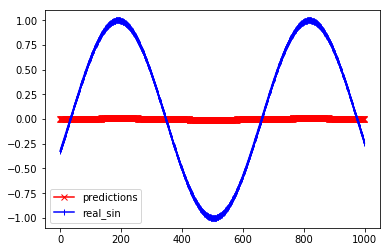

train step:0, loss: 0.43018562
train step:1000, loss: 0.001399328
train step:2000, loss: 0.00042291614
train step:3000, loss: 8.834258e-05
train step:4000, loss: 1.8323353e-05
train step:5000, loss: 5.1854586e-06
train step:6000, loss: 4.2590354e-06
train step:7000, loss: 3.9060697e-06
train step:8000, loss: 3.6587876e-06
train step:9000, loss: 3.5057192e-06
After RNN Training
Mean Square Error is : 0.0018367329612374306


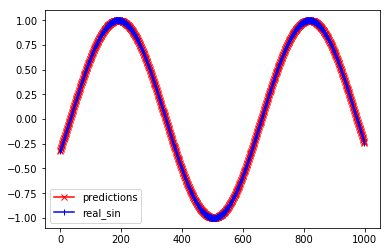

In [9]:
import numpy as np
import tensorflow as tf
import os

import matplotlib.pyplot as plt
tf.reset_default_graph()

MODEL_SAVE_PATH = "./models"
MODEL_NAME = "rnnmodel.ckpt"

'''隐藏层节点'''
HIDDEN_SIZE = 30
'''层数'''
NUM_LAYERS = 2
'''训练序列长度'''
TIMESTEPS = 10
'''训练步数'''
TRAINING_STEPS = 10000
'''bactch'''
BATCH_SIZE = 32
'''训练数据个数'''
TRAINING_EXAMPLES = 10000
'''测试数据个数'''
TESTING_EXAMPLES = 1000
'''采样间隔'''
SAMPLE_GAP = 0.01

def generate_data(seq):
    X = []
    y = []
    for i in range(len(seq) - TIMESTEPS):
        X.append([seq[i:i+TIMESTEPS]])
        y.append([seq[i+TIMESTEPS]])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

def lstm_model(X, y, is_training):
    cell = tf.nn.rnn_cell.MultiRNNCell([
        tf.nn.rnn_cell.BasicLSTMCell(HIDDEN_SIZE)
        for _ in range(NUM_LAYERS)
    ])
    
    outputs, _ = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
    output = outputs[:, -1, :]
    predictions = tf.contrib.layers.fully_connected(output, 1, activation_fn=None)
    
    if not is_training:
        return predictions, None, None
    
    loss = tf.losses.mean_squared_error(labels=y, predictions=predictions)
    
    train_op = tf.contrib.layers.optimize_loss(
        loss, tf.train.get_global_step(),optimizer="Adagrad",
        learning_rate = 0.1
    )
    return predictions, loss, train_op

def train(sess, train_X, train_y):
    ds = tf.data.Dataset.from_tensor_slices((train_X, train_y))
    ds = ds.repeat().shuffle(1000).batch(BATCH_SIZE)
    X, y = ds.make_one_shot_iterator().get_next()
    
    with tf.variable_scope("model", reuse=True):
        predictions, loss, train_op = lstm_model(X, y, True)
        
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    saver = tf.train.Saver()
    for i in range(TRAINING_STEPS):
        _, l = sess.run([train_op, loss])
        if i % 1000 == 0:
            print("train step:{}, loss: {}".format(str(i), str(l)))
            saver.save(sess, os.path.join(MODEL_SAVE_PATH, MODEL_NAME))
            
def run_eval(sess, test_X, test_y):
    ds = tf.data.Dataset.from_tensor_slices((test_X, test_y))
    ds = ds.batch(1)
    X, y = ds.make_one_shot_iterator().get_next()
    
    with tf.variable_scope("model", reuse=True):
        prediction, _, _ = lstm_model(X, [0.0], False)
        predictions = []
        labels = []
        for i in range(TESTING_EXAMPLES):
            p, l = sess.run([prediction, y])
            predictions.append(p)
            labels.append(l)
    
    predictions = np.array(predictions).squeeze()
    labels = np.array(labels).squeeze()
    rmse = np.sqrt(((predictions - labels)**2).mean(axis=0))
    print("Mean Square Error is : {}".format(rmse))
    
#     plt.figure()
#     plt.plot(predictions, label='predictions')
#     plt.plot(labels, label="real value")
#     plt.legend()
#     plt.show()
    
    plt.figure()
    plt.plot(predictions, label='predictions', marker='x', color='r')
    plt.plot(labels, label='real_sin', marker='|', color='b')
    plt.legend()
    plt.show()
    
    
test_start = (TRAINING_EXAMPLES+TIMESTEPS)*SAMPLE_GAP
test_end = test_start+(TESTING_EXAMPLES+TIMESTEPS)*SAMPLE_GAP

train_X, train_y = generate_data(np.sin(np.linspace(0, test_start, TRAINING_EXAMPLES+TIMESTEPS, dtype=np.float32)))
test_X, test_y = generate_data(np.sin(np.linspace(test_start, test_end, TESTING_EXAMPLES+TIMESTEPS, dtype=np.float32)))

# with tf.variable_scope("model"):
#     _, loss, train_op = lstm_model(X, y, True)
ds = tf.data.Dataset.from_tensor_slices((train_X, train_y))
ds = ds.repeat().shuffle(1000).batch(BATCH_SIZE)
X, y = ds.make_one_shot_iterator().get_next()
    
with tf.variable_scope("model"):
    predictions, loss, train_op = lstm_model(X, y, True)


with tf.Session() as sess:
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    print("Before RNN Training")
    run_eval(sess, test_X, test_y)
    train(sess, train_X, train_y)
    print("After RNN Training")
    run_eval(sess, test_X, test_y)
    
    




## RNN reload model

INFO:tensorflow:Restoring parameters from ./models/rnnmodel.ckpt


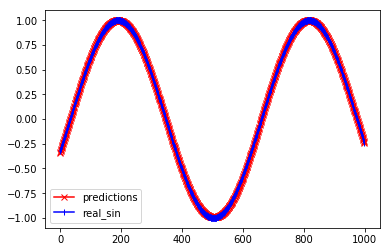

In [92]:
import numpy as np
import tensorflow as tf
import os

import matplotlib.pyplot as plt
tf.reset_default_graph()

MODEL_SAVE_PATH = "./models"
MODEL_NAME = "rnnmodel.ckpt"

'''隐藏层节点'''
HIDDEN_SIZE = 30
'''层数'''
NUM_LAYERS = 2
'''训练序列长度'''
TIMESTEPS = 10
'''训练步数'''
TRAINING_STEPS = 10000
'''bactch'''
BATCH_SIZE = 32
'''训练数据个数'''
TRAINING_EXAMPLES = 10000
'''测试数据个数'''
TESTING_EXAMPLES = 1000
'''采样间隔'''
SAMPLE_GAP = 0.01

def generate_data(seq):
    X = []
    y = []
    for i in range(len(seq) - TIMESTEPS):
        X.append([seq[i:i+TIMESTEPS]])
        y.append([seq[i+TIMESTEPS]])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

def lstm_model(X, y, is_training):
    cell = tf.nn.rnn_cell.MultiRNNCell([
        tf.nn.rnn_cell.BasicLSTMCell(HIDDEN_SIZE)
        for _ in range(NUM_LAYERS)
    ])
    
    outputs, _ = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
    output = outputs[:, -1, :]
    predictions = tf.contrib.layers.fully_connected(output, 1, activation_fn=None)
    
    if not is_training:
        return predictions, None, None
    
    loss = tf.losses.mean_squared_error(labels=y, predictions=predictions)
    
    train_op = tf.contrib.layers.optimize_loss(
        loss, tf.train.get_global_step(),optimizer="Adagrad",
        learning_rate = 0.1
    )
    return predictions, loss, train_op
  
       
g_params = tf.Graph()
with g_params.as_default():
    X = tf.placeholder(tf.float32, [None, 1, 10])
    y = tf.placeholder(tf.float32, [None, 1])
    predictions, loss, train_op = lstm_model(X, [0.0], False)
    
def load_model():
    outputs = []
    with tf.Session(graph=g_params) as sess:
        saver = tf.train.Saver()
        ckpt = tf.train.get_checkpoint_state("./models")
        model_path = ckpt.model_checkpoint_path
        saver.restore(sess, model_path)
        for i in range(TESTING_EXAMPLES):
            input_data = np.expand_dims(test_X[i], 0)
#             print("input data: {}".format(input_data.shape))
            pre = sess.run(predictions, feed_dict={X: input_data})
            outputs.append(pre)
#             print("prediction value: {}".format(pre))
    outputs = np.array(outputs).squeeze()
    plt.figure()
    plt.plot(outputs, label='predictions', marker='x', color='r')
    plt.plot(test_y, label='real_sin', marker='|', color='b')
    plt.legend()
    plt.show()
    
    
if __name__ == "__main__":
#     train_model()
    load_model()
    


